## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [28]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)

In [29]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [30]:
# cleaning and wrangling
stroke_clean <- stroke %>%
    select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
    mutate(gender = as_factor(gender), 
           bmi = as.numeric(bmi),
           smoking_status = as_factor(smoking_status),
           stroke = as_factor(stroke)) %>%
    filter(gender != "Other") #Other was removed as there was only one occurrence in the dataset

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [31]:
head(stroke_clean)

gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,228.69,36.6,formerly smoked,1
Female,61,0,0,202.21,NA,never smoked,1
Male,80,0,1,105.92,32.5,never smoked,1
Female,49,0,0,171.23,34.4,smokes,1
Female,79,1,0,174.12,24.0,never smoked,1
Male,81,0,0,186.21,29.0,formerly smoked,1


### start ###

In [32]:
stroke_subset <- stroke_clean %>%
    select(-gender, -smoking_status) %>%
    filter(!is.na(bmi))
names <- colnames(stroke_subset %>% select(-stroke))
names

[1] "age"               "hypertension"      "heart_disease"    
[4] "avg_glucose_level" "bmi"

In [33]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+hypertension+heart_disease+avg_glucose_level+bmi"

In [34]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [35]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

In [36]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [37]:
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ avg_glucose_level,0.9574187
2,stroke ~ avg_glucose_level+age,0.9574187
3,stroke ~ avg_glucose_level+age+heart_disease,0.9574187
4,stroke ~ avg_glucose_level+age+heart_disease+bmi,0.9568074
5,stroke ~ avg_glucose_level+age+heart_disease+bmi+hypertension,0.9566036


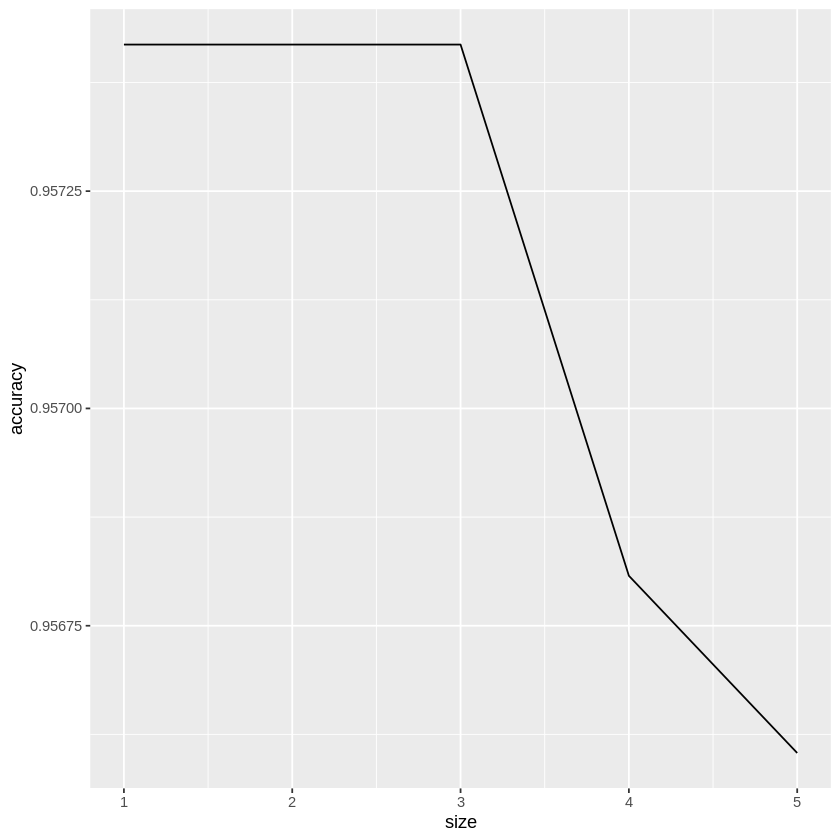

In [39]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line()